# Classifying OUV using ULMFiT model

## Imports

In [1]:
import sys
sys.executable

'/opt/miniconda3/bin/python'

In [2]:
from argparse import Namespace
from collections import Counter
import json
import os
import re
import string

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

from sklearn.metrics import confusion_matrix

from scipy.special import softmax

import pickle
import matplotlib.pyplot as plt
import random

import torchtext
from torchtext.data import get_tokenizer
tokenizer = get_tokenizer('spacy')

In [3]:
import fastai
from fastai.text.all import * 
import pandas as pd
import numpy as np
from functools import partial
import io
import os

In [4]:
print("PyTorch version {}".format(torch.__version__))
print("GPU-enabled installation? {}".format(torch.cuda.is_available()))

PyTorch version 1.7.0
GPU-enabled installation? False


In [5]:
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print(device)

cpu


In [6]:
class Vocabulary(object):
    """Class to process text and extract vocabulary for mapping"""

    def __init__(self, token_to_idx=None):
        """
        Args:
            token_to_idx (dict): a pre-existing map of tokens to indices
            add_unk (bool): a flag that indicates whether to add the UNK token
            unk_token (str): the UNK token to add into the Vocabulary
        """

        if token_to_idx is None:
            token_to_idx = {}
        self._token_to_idx = token_to_idx

        self._idx_to_token = {idx: token 
                              for token, idx in self._token_to_idx.items()}
                
    def to_serializable(self):
        """ returns a dictionary that can be serialized """
        return {'token_to_idx': self._token_to_idx}

    @classmethod
    def from_serializable(cls, contents):
        """ instantiates the Vocabulary from a serialized dictionary """
        return cls(**contents)

    def add_token(self, token):
        """Update mapping dicts based on the token.

        Args:
            token (str): the item to add into the Vocabulary
        Returns:
            index (int): the integer corresponding to the token
        """
        if token in self._token_to_idx:
            index = self._token_to_idx[token]
        else:
            index = len(self._token_to_idx)
            self._token_to_idx[token] = index
            self._idx_to_token[index] = token
        return index
    
    def add_many(self, tokens):
        """Add a list of tokens into the Vocabulary
        
        Args:
            tokens (list): a list of string tokens
        Returns:
            indices (list): a list of indices corresponding to the tokens
        """
        return [self.add_token(token) for token in tokens]

    def lookup_token(self, token):
        """Retrieve the index associated with the token 
          or the UNK index if token isn't present.
        
        Args:
            token (str): the token to look up 
        Returns:
            index (int): the index corresponding to the token
        Notes:
            `unk_index` needs to be >=0 (having been added into the Vocabulary) 
              for the UNK functionality 
        """
        return self._token_to_idx[token]

    def lookup_index(self, index):
        """Return the token associated with the index
        
        Args: 
            index (int): the index to look up
        Returns:
            token (str): the token corresponding to the index
        Raises:
            KeyError: if the index is not in the Vocabulary
        """
        if index not in self._idx_to_token:
            raise KeyError("the index (%d) is not in the Vocabulary" % index)
        return self._idx_to_token[index]

    def __str__(self):
        return "<Vocabulary(size=%d)>" % len(self)

    def __len__(self):
        return len(self._token_to_idx)

In [7]:
class SequenceVocabulary(Vocabulary):
    def __init__(self, token_to_idx=None, unk_token='xxunk',
                 mask_token='xxpad', begin_seq_token="xxbos",
                 end_seq_token="xxeos"):

        super(SequenceVocabulary, self).__init__(token_to_idx)

        self._mask_token = mask_token
        self._unk_token = unk_token
        self._begin_seq_token = begin_seq_token
        self._end_seq_token = end_seq_token

        self.mask_index = 1
        self.unk_index = 0
        self.begin_seq_index = 2
        self.end_seq_index = 3

    def to_serializable(self):
        contents = super(SequenceVocabulary, self).to_serializable()
        contents.update({'unk_token': self._unk_token,
                         'mask_token': self._mask_token,
                         'begin_seq_token': self._begin_seq_token,
                         'end_seq_token': self._end_seq_token})
        return contents
    
    @classmethod
    def from_serializable(cls, contents):
        """ instantiates the Vocabulary from a serialized dictionary """
        return cls(**contents)

    
    def lookup_token(self, token):
        """Retrieve the index associated with the token 
          or the UNK index if token isn't present.
        
        Args:
            token (str): the token to look up 
        Returns:
            index (int): the index corresponding to the token
        Notes:
            `unk_index` needs to be >=0 (having been added into the Vocabulary) 
              for the UNK functionality 
        """
        if self.unk_index >= 0:
            return self._token_to_idx.get(token, self.unk_index)
        else:
            return self._token_to_idx[token]

In [8]:
class OuvVectorizer(object):
    """ The Vectorizer which coordinates the Vocabularies and puts them to use"""
    def __init__(self, ouv_vocab):
        """
        Args:
            review_vocab (Vocabulary): maps words to integers
        """
        self.ouv_vocab = ouv_vocab
        
    def vectorize(self, data, vector_length = -1):
        """Create a collapsed one-hit vector for the ouv data
        
        Args:
            data (str): the ouv description data
            vector_length (int): an argument for forcing the length of index vector
        Returns:
            the vectorized data (np.ndarray)
        """
        indices = []
        indices.extend(self.ouv_vocab.lookup_token(token) for token in data.split(' '))
        #indices.append(self.ouv_vocab.end_seq_index)
        
        if vector_length < 0:
            vector_length = len(indices)
            
        out_vector = np.zeros(vector_length, dtype=np.int64)
        out_vector[:len(indices)] = indices
        out_vector[len(indices):] = self.ouv_vocab.mask_index
        
        return out_vector, len(indices)

    @classmethod
    def from_dataframe(cls, vocab, cutoff=5):
        """Instantiate the vectorizer from the dataset dataframe
        
        Args:
            ouv_df (pandas.DataFrame): the ouv dataset
            cutoff (int): the parameter for frequency-based filtering
        Returns:
            an instance of the OuvVectorizer
        """
        
        # Add top words if count > provided count
        #word_counts = Counter()
        #for data in ouv_df.data:
        #    for word in data.split(' '):
        #        if word not in string.punctuation:
        #            word_counts[word] += 1
        
        ouv_vocab = SequenceVocabulary()
        for token in vocab:
            ouv_vocab.add_token(token)
        #for word, count in word_counts.items():
        #    if count > cutoff:
        #        ouv_vocab.add_token(word)

        return cls(ouv_vocab)

    @classmethod
    def from_serializable(cls, contents):
        """Instantiate a OuvVectorizer from a serializable dictionary
        
        Args:
            contents (dict): the serializable dictionary
        Returns:
            an instance of the OuvVectorizer class
        """
        ouv_vocab = SequenceVocabulary.from_serializable(contents['ouv_vocab'])
        
        return cls(ouv_vocab=ouv_vocab)

    def to_serializable(self):
        """Create the serializable dictionary for caching
        
        Returns:
            contents (dict): the serializable dictionary
        """
        return {'ouv_vocab': self.ouv_vocab.to_serializable()}

In [9]:
class OuvDataset(Dataset):
    def __init__(self, ouv_df, vectorizer, vocab):
        """
        Args:
            ouv_df (pandas.DataFrame): the dataset
            vectorizer (ReviewVectorizer): vectorizer instantiated from dataset
        """
        self.ouv_df = ouv_df
        self._vectorizer = vectorizer
        self.vocab = vocab
        
        # +0 if not using begin_seq and end seq, +1 if only using begin_seq, +2 if using both begin and end seq tokens
        measure_len = lambda context: len(context.split(" "))
        self._max_seq_length = max(map(measure_len, ouv_df.data)) + 0

        self.train_df = self.ouv_df[self.ouv_df.split=='train']
        self.train_size = len(self.train_df)

        self.val_df = self.ouv_df[self.ouv_df.split=='dev']
        self.validation_size = len(self.val_df)

        self.test_df = self.ouv_df[self.ouv_df.split=='test']
        self.test_size = len(self.test_df)

        self._lookup_dict = {'train': (self.train_df, self.train_size),
                             'val': (self.val_df, self.validation_size),
                             'test': (self.test_df, self.test_size)}

        self.set_split('train')

    @classmethod
    def load_dataset_and_make_vectorizer(cls, ouv_csv, cutoff, vocab):
        """Load dataset and make a new vectorizer from scratch
        
        Args:
            ouv_csv (str): location of the dataset
            cutoff (int): the boundary to set the words into unknown
        Returns:
            an instance of OuvDataset
        """
        ouv_df = pd.read_csv(ouv_csv)
        train_ouv_df = ouv_df[ouv_df.split=='train']
        return cls(ouv_df, OuvVectorizer.from_dataframe(cutoff=cutoff, vocab=vocab), vocab=vocab)
    
    @classmethod
    def load_dataset_and_load_vectorizer(cls, ouv_csv, vectorizer_filepath, vocab):
        """Load dataset and the corresponding vectorizer. 
        Used in the case in the vectorizer has been cached for re-use
        
        Args:
            ouv_csv (str): location of the dataset
            vectorizer_filepath (str): location of the saved vectorizer
        Returns:
            an instance of OuvDataset
        """
        ouv_df = pd.read_csv(ouv_csv)
        vectorizer = cls.load_vectorizer_only(vectorizer_filepath)
        return cls(ouv_df, vectorizer, vocab=vocab)

    @staticmethod
    def load_vectorizer_only(vectorizer_filepath):
        """a static method for loading the vectorizer from file
        
        Args:
            vectorizer_filepath (str): the location of the serialized vectorizer
        Returns:
            an instance of ReviewVectorizer
        """
        with open(vectorizer_filepath) as fp:
            return OuvVectorizer.from_serializable(json.load(fp))

    def save_vectorizer(self, vectorizer_filepath):
        """saves the vectorizer to disk using json
        
        Args:
            vectorizer_filepath (str): the location to save the vectorizer
        """
        with open(vectorizer_filepath, "w") as fp:
            json.dump(self._vectorizer.to_serializable(), fp)

    def get_vectorizer(self):
        """ returns the vectorizer """
        return self._vectorizer

    def set_split(self, split="train"):
        """ selects the splits in the dataset using a column in the dataframe 
        
        Args:
            split (str): one of "train", "val", or "test"
        """
        self._target_split = split
        self._target_df, self._target_size = self._lookup_dict[split]

    def __len__(self):
        return self._target_size

    def __getitem__(self, index):
        """the primary entry point method for PyTorch datasets
        
        Args:
            index (int): the index to the data point 
        Returns:
            a dictionary holding the data point's features (x_data) and component for labels (y_target and y_fuzzy)
        """
        row = self._target_df.iloc[index]

        ouv_vector, vec_length = \
            self._vectorizer.vectorize(row.data, self._max_seq_length)

        true_label = \
            np.fromstring(row.true[1:-1],dtype=float, sep=' ')
        
        if len(true_label)==10:
            true_label = np.append(true_label,0.0)
        
        fuzzy_label = \
            np.fromstring(row.fuzzy[1:-1],dtype=float, sep=' ')

        return {'x_data': ouv_vector,
                'y_target': true_label,
                'y_fuzzy': fuzzy_label,
                'x_length': vec_length,
                'id': row.id
               }

    def get_num_batches(self, batch_size):
        """Given a batch size, return the number of batches in the dataset
        
        Args:
            batch_size (int)
        Returns:
            number of batches in the dataset
        """
        return len(self) // batch_size  
    
def generate_batches(dataset, batch_size, shuffle=True,
                     drop_last=True, device="cpu"):
    """
    A generator function which wraps the PyTorch DataLoader. It will 
      ensure each tensor is on the write device location.
    """
    dataloader = DataLoader(dataset=dataset, batch_size=batch_size,
                            shuffle=shuffle, drop_last=drop_last)

    for data_dict in dataloader:
        out_data_dict = {}
        for name, tensor in data_dict.items():
            out_data_dict[name] = data_dict[name].to(device)
        yield out_data_dict

In [10]:
def set_seed_everywhere(seed, cuda):
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    if cuda:
        torch.cuda.manual_seed_all(seed)

def handle_dirs(dirpath):
    if not os.path.exists(dirpath):
        os.makedirs(dirpath)

def load_glove_from_file(glove_filepath):
    """
    Load the GloVe embeddings 
    
    Args:
        glove_filepath (str): path to the glove embeddings file 
    Returns:
        word_to_index (dict), embeddings (numpy.ndarary)
    """

    word_to_index = {}
    embeddings = []
    with open(glove_filepath, "r") as fp:
        for index, line in enumerate(fp):
            line = line.split(" ") # each line: word num1 num2 ...
            word_to_index[line[0]] = index # word = line[0] 
            embedding_i = np.array([float(val) for val in line[1:]])
            embeddings.append(embedding_i)
    return word_to_index, np.stack(embeddings)

def make_embedding_matrix(glove_filepath, words):
    """
    Create embedding matrix for a specific set of words.
    
    Args:
        glove_filepath (str): file path to the glove embeddigns
        words (list): list of words in the dataset
    """
    word_to_idx, glove_embeddings = load_glove_from_file(glove_filepath)
    embedding_size = glove_embeddings.shape[1]
    
    final_embeddings = np.zeros((len(words), embedding_size))

    for i, word in enumerate(words):
        if word in word_to_idx:
            final_embeddings[i, :] = glove_embeddings[word_to_idx[word]]
        else:
            embedding_i = torch.ones(1, embedding_size)
            torch.nn.init.xavier_uniform_(embedding_i)
            final_embeddings[i, :] = embedding_i

    return final_embeddings

In [11]:
args = Namespace(
    # Data and Path information
    frequency_cutoff=1,
    model_state_file='model.pth',
    ouv_csv='Data/ouv_with_splits_full.csv',
    big_ouv_csv='Data/all_with_splits_full.csv',
    prior_csv = 'Data/Coappearance_matrix.csv',
    sm_csv = 'Data/Social_media.csv',
    save_dir='model_storage/ulmfit/',
    vectorizer_file='vectorizer.json',
    # Model hyper parameters
    glove_filepath='Data/glove/glove.6B.300d.txt', 
    use_glove=False,
    freeze = True,
    embedding_size=400, 
    hidden_dim=64, 
    bi = False,
    # Training hyper parameters
    batch_size=64,
    early_stopping_criteria=3,
    learning_rate=2e-2,
    l2=1e-5,
    dropout_p=0,
    k = 3,
    fuzzy = True,
    fuzzy_how = 'prior',
    fuzzy_lambda = 0.1,
    num_epochs=10,
    seed=1337,
    # Runtime options
    catch_keyboard_interrupt=True,
    cuda=True,
    expand_filepaths_to_save_dir=True,
    reload_from_files=False,
)

classes = ['Criteria i', 'Criteria ii', 'Criteria iii', 'Criteria iv', 'Criteria v', 'Criteria vi', 
              'Criteria vii', 'Criteria viii', 'Criteria ix', 'Criteria x', 'Others']

if args.expand_filepaths_to_save_dir:
    args.vectorizer_file = os.path.join(args.save_dir,
                                        args.vectorizer_file)

    args.model_state_file = os.path.join(args.save_dir,
                                         args.model_state_file)
    
    print("Expanded filepaths: ")
    print("\t{}".format(args.vectorizer_file))
    print("\t{}".format(args.model_state_file))
    
# Check CUDA
if not torch.cuda.is_available():
    args.cuda = False

print("Using CUDA: {}".format(args.cuda))

args.device = torch.device("cuda" if args.cuda else "cpu")

# Set seed for reproducibility
set_seed_everywhere(args.seed, args.cuda)

# handle dirs
handle_dirs(args.save_dir)

Expanded filepaths: 
	model_storage/ulmfit/vectorizer.json
	model_storage/ulmfit/model.pth
Using CUDA: False


In [12]:
def make_train_state(args):
    return {'stop_early': False,
            'early_stopping_step': 0,
            'early_stopping_best_k_acc_val': 0,
            'learning_rate': args.learning_rate,
            'epoch_index': 0,
            'train_loss': [],
            'train_1_acc': [],
            'train_k_acc': [],
            'train_k_jac': [],
            'val_loss': [],
            'val_1_acc': [],
            'val_k_acc': [],
            'val_k_jac': [],
            'test_loss': -1,
            'test_1_acc': -1,
            'test_k_acc':-1,
            'test_k_jac':-1,
            'model_filename': args.model_state_file}

def update_train_state(args, model, train_state):
    """Handle the training state updates.

    Components:
     - Early Stopping: Prevent overfitting.
     - Model Checkpoint: Model is saved if the model is better

    :param args: main arguments
    :param model: model to train
    :param train_state: a dictionary representing the training state values
    :returns:
        a new train_state
    """

    # Save one model at least
    if train_state['epoch_index'] == 0:
        torch.save(model.state_dict(), train_state['model_filename'])
        train_state['stop_early'] = False

    # Save model if performance improved
    elif train_state['epoch_index'] >= 1:
        acc_tm1, acc_t = train_state['val_k_acc'][-2:]

        # If accuracy worsened
        if acc_t <= train_state['early_stopping_best_k_acc_val']:
            # Update step
            train_state['early_stopping_step'] += 1
        # Loss decreased
        else:
            # Save the best model from sklearn
            if acc_t > train_state['early_stopping_best_k_acc_val']:
                train_state['early_stopping_best_k_acc_val'] = acc_t
                torch.save(model.state_dict(), train_state['model_filename'])
                
            # Reset early stopping step
            train_state['early_stopping_step'] = 0

        # Stop early ?
        train_state['stop_early'] = \
            train_state['early_stopping_step'] >= args.early_stopping_criteria

    return train_state

In [13]:
def compute_cross_entropy(y_pred, y_target):
    y_target = y_target.cpu().float()
    y_pred = y_pred.cpu().float()
    criterion = nn.BCEWithLogitsLoss()
    return criterion(y_target, y_pred)

def compute_1_accuracy(y_pred, y_target):
    y_target_indices = y_target.max(dim=1)[1]
    y_pred_indices = y_pred.max(dim=1)[1]
    n_correct = torch.eq(y_pred_indices, y_target_indices).sum().item()
    return n_correct / len(y_pred_indices) * 100

def compute_k_accuracy(y_pred, y_target, k=3):
    y_pred_indices = y_pred.topk(k, dim=1)[1]
    y_target_indices = y_target.max(dim=1)[1]
    n_correct = torch.tensor([y_pred_indices[i] in y_target_indices[i] for i in range(len(y_pred))]).sum().item()
    return n_correct / len(y_pred_indices) * 100

def compute_k_jaccard_index(y_pred, y_target, k=3):
    y_target_indices = y_target.topk(k, dim=1)[1]
    y_pred_indices = y_pred.max(dim=1)[1]
    jaccard = torch.tensor([len(np.intersect1d(y_target_indices[i], y_pred_indices[i]))/
                            len(np.union1d(y_target_indices[i], y_pred_indices[i]))
                            for i in range(len(y_pred))]).sum().item()
    return jaccard / len(y_pred_indices)

def compute_jaccard_index(y_pred, y_target, k=3, multilabel=False):
    
    threshold = 1.0/(k+1)
    threshold_2 = 0.5
    
    if multilabel:
        y_pred_indices = y_pred.gt(threshold_2)
    else:
        y_pred_indices = y_pred.gt(threshold)
    
    y_target_indices = y_target.gt(threshold)
        
    jaccard = ((y_target_indices*y_pred_indices).sum(axis=1)/((y_target_indices+y_pred_indices).sum(axis=1)+1e-8)).sum().item()
    return jaccard / len(y_pred_indices)

In [14]:
def softmax_sensitive(T):
    T = np.exp(T) - np.exp(0) + 1e-9
    if len(T.shape)==1:
        return T/T.sum()
    return  T/(T.sum(axis=1).unsqueeze(1))

In [15]:
def cross_entropy(pred, soft_targets):
    logsoftmax = nn.LogSoftmax(dim=1)
    return torch.mean(torch.sum(- soft_targets * logsoftmax(pred), 1))

In [16]:
# convert a df to tensor to be used in pytorch
def df_to_tensor(df):
    device = args.device
    return torch.from_numpy(df.values).float().to(device)

In [17]:
def get_prior():
    prior = pd.read_csv(args.prior_csv,sep=';',names=classes[:-1], skiprows=1)
    prior['Others'] = 1
    prior = prior.T
    prior['Others'] = 1
    prior = df_to_tensor(prior)
    return(prior)

In [18]:
def compute_fuzzy_label(y_target, y_fuzzy, fuzzy=False, how='uni', lbd=0):
    '''
    Using two sets of prediction labels and fuzziness parameters to compute the fuzzy label in the form as 
    a distribution over classes
    
    Args:
    y_target (torch.Tensor) of shape (n_batch, n_classes): the true label of the ouv description
    y_fuzzy (torch.Tensor) of shape (n_batch, n_classes): the fuzzy label of the ouv description
    fuzzy (bool): whether or not to turn on the fuzziness option
    how (string): the way fuzziness weights are used, one of the options in {'uni', 'prior'}
    lbd (float): the scaler applied to the fuzziness of the label
    
    Returns:
    A pytorch Tensor of shape (n_batch, n_classes): The processed label in the form of distribution that add to 1
    '''
    assert y_target.shape == y_fuzzy.shape, 'target labels must have the same size'
    assert how in {'uni', 'prior', 'origin'}, '''how must be one of the two options in {'uni', 'prior'}'''
    
    if not fuzzy:
        return softmax_sensitive(y_target)
    
    if how == 'uni':
        y_label = y_target + lbd * y_fuzzy
        return softmax_sensitive(y_label)
    
    ### TO DO ###
    elif how == 'prior':
        prior = get_prior()
        y_inter = torch.matmul(y_target.float(),prior)
        y_inter = y_inter/(y_inter.max(dim=1, keepdim=True)[0])
        y_label = y_target + lbd * y_fuzzy * y_inter
        return softmax_sensitive(y_label)
    
    else:
        y_label = y_target + lbd
        return softmax_sensitive(y_label)

In [19]:
def load_encoder(model, file, device=None):
        "Load the encoder `file` from the model directory, optionally ensuring it's on `device`"
        encoder = model[0]
        if device is None: device = args.device
        if hasattr(encoder, 'module'): encoder = encoder.module
        distrib_barrier()
        wgts = torch.load(args.save_dir + file+'.pth', map_location=device)
        encoder.load_state_dict(clean_raw_keys(wgts))
        for param in encoder.parameters():
            param.requires_grad = False
        #model.freeze()
        return model

In [20]:
ouv_df = pd.read_csv(args.big_ouv_csv)

In [21]:
data_lm = TextDataLoaders.from_df(ouv_df, text_col = 'data', label_col = 'true', path = "", is_lm=True)
vocab = data_lm.vocab

/opt/miniconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [22]:
if args.reload_from_files:
    # training from a checkpoint
    dataset = OuvDataset.load_dataset_and_load_vectorizer(args.ouv_csv, args.vectorizer_file, vocab=vocab)

else:
    # create dataset and vectorizer
    dataset = OuvDataset.load_dataset_and_make_vectorizer(args.ouv_csv, cutoff=args.frequency_cutoff, vocab=vocab)
    dataset.save_vectorizer(args.vectorizer_file)    

vectorizer = dataset.get_vectorizer()
set_seed_everywhere(args.seed, args.cuda)

# Use GloVe or randomly initialized embeddings
if args.use_glove:
    words = vectorizer.ouv_vocab._token_to_idx.keys()
    embeddings = make_embedding_matrix(glove_filepath=args.glove_filepath, 
                                       words=words)
    print("Using pre-trained embeddings")
else:
    print("Not using pre-trained embeddings")
    embeddings = None

Not using pre-trained embeddings


## Train a Domain-specific Language Model using whole data

### Loading Data and Prepare Model

In [21]:
ouv_df = pd.read_csv(args.big_ouv_csv)

In [22]:
data_lm = TextDataLoaders.from_df(ouv_df, text_col = 'data', label_col = 'true', path = "", is_lm=True)
vocab = data_lm.vocab

/opt/miniconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [23]:
len(vocab)

10536

In [20]:
# Language model data
data_lm = TextDataLoaders.from_df(ouv_df, text_col = 'data', label_col = 'true', path = "", is_lm=True)

/opt/miniconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [91]:
learn = language_model_learner(data_lm, AWD_LSTM, metrics=[accuracy, Perplexity()], path='', wd=0.1)

In [92]:
learn = learn.load('lm')

In [115]:
learn.model

SequentialRNN(
  (0): AWD_LSTM(
    (encoder): Embedding(10536, 400, padding_idx=1)
    (encoder_dp): EmbeddingDropout(
      (emb): Embedding(10536, 400, padding_idx=1)
    )
    (rnns): ModuleList(
      (0): WeightDropout(
        (module): LSTM(400, 1152, batch_first=True)
      )
      (1): WeightDropout(
        (module): LSTM(1152, 1152, batch_first=True)
      )
      (2): WeightDropout(
        (module): LSTM(1152, 400, batch_first=True)
      )
    )
    (input_dp): RNNDropout()
    (hidden_dps): ModuleList(
      (0): RNNDropout()
      (1): RNNDropout()
      (2): RNNDropout()
    )
  )
  (1): LinearDecoder(
    (decoder): Linear(in_features=400, out_features=10536, bias=True)
    (output_dp): RNNDropout()
  )
)

### Fitting Language Model

In [63]:
learn.fit_one_cycle(1,1e-2)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,4.465606,3.843865,0.341763,46.705639,13:27


In [65]:
learn.save('1epoch')

Path('models/1epoch.pth')

In [66]:
learn = learn.load('1epoch')

In [67]:
learn.unfreeze()
learn.fit_one_cycle(10, 1e-3)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,4.051659,3.704584,0.355655,40.633137,20:04
1,3.915759,3.627175,0.362101,37.606422,19:40
2,3.793126,3.554804,0.367985,34.980976,19:53
3,3.680459,3.509872,0.372307,33.443985,19:34
4,3.585886,3.476479,0.375953,32.345627,19:20
5,3.493525,3.454393,0.377256,31.639082,20:00
6,3.430653,3.438308,0.379044,31.134241,19:14
7,3.364055,3.429951,0.380467,30.875135,19:27
8,3.321345,3.427366,0.380578,30.795437,20:24
9,3.303921,3.427146,0.380355,30.788652,20:49


### Saving Trained Encoder and Language Model

In [68]:
learn.save_encoder('finetuned')

In [69]:
learn.save('lm')

Path('models/lm.pth')

### Some Inference on the Effect of Language Model

In [72]:
TEXT = "This site is unique because"
N_WORDS = 50
N_SENTENCES = 2
preds = [learn.predict(TEXT, N_WORDS, temperature=0.75) 
         for _ in range(N_SENTENCES)]

In [73]:
print("\n".join(preds))

This site is unique because it is the only example of a complex of karst complexes that is clearly recognised as being of outstanding universal value . the island of zanzibar has been inscribed as a world heritage site in < num > the inscriptions , which bear witness to the civilisation of
This site is unique because of the large number of species of birds that make it into permanent , species rich and impressive populations the churches of the romanesque cathedral , the cathedral of st demetrius and st john s cemetery have outstanding architectural and artistic significance for the settlers who were northern merchants


In [74]:
TEXT = "This architecture has a special layout"
N_WORDS = 50
N_SENTENCES = 2
preds = [learn.predict(TEXT, N_WORDS, temperature=0.75) 
         for _ in range(N_SENTENCES)]

In [75]:
print("\n".join(preds))

This architecture has a special layout , , especially in the form of the body of the building . the planet s primary feature is the addition of the ideal island , which lies at an elevation of < num > m above the sea floor , and is home to some < num >
This architecture has a special layout with a high degree of integrity and integrity it was composed of fortified fortified fortifications built in the < num > th century , the first of which was built in < num > on the site of the old city , and which still exists today the


### Loading Model for Classifier Training

In [25]:
classifier = get_text_classifier(AWD_LSTM, len(vocab), len(classes), seq_len=72, config=None, drop_mult=0.5, lin_ftrs=None,
                        ps=None, pad_idx=1, max_len=72*20, y_range=None)
classifier = load_encoder(classifier, 'finetuned')

In [26]:
def freeze_to(model,n):
    param_lists = [param for param in model[0].parameters()]
    frozen_idx = n if n >= 0 else len(param_lists) + n*4
    if frozen_idx >= len(param_lists):
        warn(f"Freezing {frozen_idx} groups; model has {len(param_lists)}; whole model is frozen.")
    for i in range(len(param_lists)):
        if i < frozen_idx:
            param_lists[i].requires_grad = False
        else:
            param_lists[i].requires_grad = True

## Loading Trained Model

### Option 1 LS Model

In [27]:
with open(args.save_dir+'hyperdict_fuzzy.p', 'rb') as fp:
    hyperdict_fuzzy = pickle.load(fp)
    train_state = hyperdict_fuzzy[('prior', 0.1)]

In [28]:
classifier.load_state_dict(torch.load(args.save_dir+'1337/model.pth',map_location=torch.device('cpu')))
classifier.eval()

SequentialRNN(
  (0): SentenceEncoder(
    (module): AWD_LSTM(
      (encoder): Embedding(10536, 400, padding_idx=1)
      (encoder_dp): EmbeddingDropout(
        (emb): Embedding(10536, 400, padding_idx=1)
      )
      (rnns): ModuleList(
        (0): WeightDropout(
          (module): LSTM(400, 1152, batch_first=True)
        )
        (1): WeightDropout(
          (module): LSTM(1152, 1152, batch_first=True)
        )
        (2): WeightDropout(
          (module): LSTM(1152, 400, batch_first=True)
        )
      )
      (input_dp): RNNDropout()
      (hidden_dps): ModuleList(
        (0): RNNDropout()
        (1): RNNDropout()
        (2): RNNDropout()
      )
    )
  )
  (1): PoolingLinearClassifier(
    (layers): Sequential(
      (0): LinBnDrop(
        (0): BatchNorm1d(1200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (1): Dropout(p=0.2, inplace=False)
        (2): Linear(in_features=1200, out_features=50, bias=False)
        (3): ReLU(inplace=True

### Option 2 Baseline w/o LS

In [222]:
with open(args.save_dir+'hyperdict_fuzzy.p', 'rb') as fp:
    hyperdict_fuzzy = pickle.load(fp)
    train_state = hyperdict_fuzzy[('prior', 0)]

In [241]:
classifier.load_state_dict(torch.load(args.save_dir+'baseline/model.pth',map_location=torch.device('cpu')))
classifier.eval()

SequentialRNN(
  (0): SentenceEncoder(
    (module): AWD_LSTM(
      (encoder): Embedding(10536, 400, padding_idx=1)
      (encoder_dp): EmbeddingDropout(
        (emb): Embedding(10536, 400, padding_idx=1)
      )
      (rnns): ModuleList(
        (0): WeightDropout(
          (module): LSTM(400, 1152, batch_first=True)
        )
        (1): WeightDropout(
          (module): LSTM(1152, 1152, batch_first=True)
        )
        (2): WeightDropout(
          (module): LSTM(1152, 400, batch_first=True)
        )
      )
      (input_dp): RNNDropout()
      (hidden_dps): ModuleList(
        (0): RNNDropout()
        (1): RNNDropout()
        (2): RNNDropout()
      )
    )
  )
  (1): PoolingLinearClassifier(
    (layers): Sequential(
      (0): LinBnDrop(
        (0): BatchNorm1d(1200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (1): Dropout(p=0.2, inplace=False)
        (2): Linear(in_features=1200, out_features=50, bias=False)
        (3): ReLU(inplace=True

In [29]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters())
count_parameters(classifier)

24550730

In [224]:
# compute the loss & accuracy on the test set using the best available model
set_seed_everywhere(args.seed, args.cuda)
loss_func = cross_entropy
#classifier.load_state_dict(torch.load(train_state['model_filename']))
#classifier = classifier.to(args.device)

dataset.set_split('test')
batch_generator = generate_batches(dataset, 
                                   batch_size=args.batch_size, 
                                   device=args.device)
running_loss = 0.
running_1_acc = 0.
running_k_acc = 0.
running_k_jac = 0.
classifier.eval()

for batch_index, batch_dict in enumerate(batch_generator):
    
    # get the data compute fuzzy labels
    X = batch_dict['x_data']

    y_target = batch_dict['y_target']
    y_fuzzy = batch_dict['y_fuzzy']

    Y = compute_fuzzy_label(y_target, y_fuzzy, fuzzy= args.fuzzy, 
                            how=args.fuzzy_how, lbd = args.fuzzy_lambda)

    # compute the output
    with torch.no_grad():
        y_pred = classifier(X)[0]

    # compute the loss
    loss = loss_func(y_pred, Y)
    loss_t = loss.item()
    running_loss += (loss_t - running_loss) / (batch_index + 1)

    # compute the accuracy
    acc_1_t = compute_1_accuracy(y_pred, y_target)
    acc_k_t = compute_k_accuracy(y_pred, y_target, args.k)
    jac_k_t = compute_jaccard_index(y_pred, y_target, args.k)

    running_1_acc += (acc_1_t - running_1_acc) / (batch_index + 1)
    running_k_acc += (acc_k_t - running_k_acc) / (batch_index + 1)
    running_k_jac += (jac_k_t - running_k_jac) / (batch_index + 1)

train_state['test_loss'] = running_loss
train_state['test_1_acc'] = running_1_acc
train_state['test_k_acc'] = running_k_acc
train_state['test_k_jac'] = running_k_jac

In [207]:
#LS Model
train_state

{'stop_early': True,
 'early_stopping_step': 3,
 'early_stopping_best_k_acc_val': 94.3359375,
 'learning_rate': 0.02,
 'epoch_index': 7,
 'train_loss': [1.317077281648767,
  1.2605138109592569,
  1.0280631605861255,
  0.8563412818072178,
  0.8161277029345488,
  0.799169392660451,
  0.7933862136873495,
  0.7829414117187636],
 'train_1_acc': [52.745535714285715,
  55.15625,
  66.87500000000001,
  75.93750000000001,
  77.61160714285718,
  78.77232142857142,
  79.01785714285711,
  80.35714285714286],
 'train_k_acc': [87.70089285714286,
  88.48214285714286,
  93.59375000000003,
  96.8526785714286,
  97.47767857142858,
  98.23660714285717,
  98.01339285714289,
  97.92410714285717],
 'train_k_jac': [0.19667853808828764,
  0.2042666726878711,
  0.21074838978903632,
  0.21338205337524413,
  0.21399385694946568,
  0.2147677530135427,
  0.2148703260081155,
  0.21484508088656837],
 'val_loss': [1.1491646554898864,
  1.1290186723900748,
  1.0530891137511653,
  1.0253822197406395,
  1.00600797225894

In [225]:
#Baseline
train_state

{'stop_early': True,
 'early_stopping_step': 3,
 'early_stopping_best_k_acc_val': 93.9453125,
 'learning_rate': 0.02,
 'epoch_index': 7,
 'train_loss': [1.2564197204045884,
  1.190402439515455,
  0.9138767724905221,
  0.7031986134363143,
  0.6537914813493433,
  0.6345267694804869,
  0.6277358806501516,
  0.6202104856876341],
 'train_1_acc': [52.65625,
  55.3125,
  66.69642857142857,
  76.31696428571428,
  78.10267857142856,
  79.21875000000003,
  79.8660714285714,
  79.93303571428574],
 'train_k_acc': [87.58928571428574,
  88.39285714285714,
  93.88392857142857,
  96.6964285714286,
  97.00892857142857,
  97.90178571428571,
  97.52232142857139,
  97.76785714285714],
 'train_k_jac': [0.1981719507702759,
  0.20549957730940405,
  0.21371926580156597,
  0.21728670937674383,
  0.21784828922578273,
  0.21953054538794925,
  0.2196302837559155,
  0.21900271049567638],
 'val_loss': [1.073857385544383,
  1.1019409043499477,
  0.9323346340491093,
  0.9113813801002052,
  0.8923210292044449,
  0.883

## Inference

In [30]:
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r"([.,!?])", r" \1 ", text)
    text = re.sub(r"[^a-zA-Z.,!?]+", r" ", text)
    return text

In [31]:
def predict_rating(text, classifier, vectorizer, classes, k=1):
    """Predict the rating of a review
    
    Args:
        text (str): the text of the description
        classifier (ReviewClassifier): the trained model
        vectorizer (ReviewVectorizer): the corresponding vectorizer
        classes (list of str): The name of the ouv classes
        k (int): show the largest k prediction, default to 1
    """
    ouv = preprocess_text(text)
    
    classifier.eval()
    vectorized_ouv = torch.tensor(vectorizer.vectorize(ouv)[0])
    X = vectorized_ouv.view(1,-1)
    result = classifier(vectorized_ouv.unsqueeze(0))[0]
    result = F.softmax(result, dim=1)
    
    if k==1:
        pred_id = result.argmax().item()
        return (classes[pred_id], result[0][pred_id])
    else:
        pred_indices = [i.item() for i in result.topk(k)[1][0]]
        output = []
        for pred_id in pred_indices:
            output.append((classes[pred_id],result[0][pred_id].item()))
        return output

In [32]:
test_ouv = 'this is a very old building dating back to 13th century'

prediction = predict_rating(test_ouv,classifier,vectorizer,classes)
print('{} -> {} with a probability of {:0.2f}'.format(test_ouv, prediction[0],prediction[1]))

this is a very old building dating back to 13th century -> Criteria iii with a probability of 0.67


In [33]:
test_ouv = 'this is a very old building dating back to 13th century'
k=3
predictions = predict_rating(test_ouv,classifier,vectorizer,classes,k)

print("Top {} predictions:".format(k))
print("===================")
for prediction in predictions:
    print('{} -> {} with a probability of {:0.2f}'.format(test_ouv, prediction[0],prediction[1]))

Top 3 predictions:
this is a very old building dating back to 13th century -> Criteria iii with a probability of 0.67
this is a very old building dating back to 13th century -> Criteria iv with a probability of 0.22
this is a very old building dating back to 13th century -> Criteria ii with a probability of 0.05


In [34]:
test_ouv = 'The particular layout of the complex is unique to this site'
k=3
predictions = predict_rating(test_ouv,classifier,vectorizer,classes,k)

print("Top {} predictions:".format(k))
print("===================")
for prediction in predictions:
    print('{} -> {} with a probability of {:0.2f}'.format(test_ouv, prediction[0],prediction[1]))

Top 3 predictions:
The particular layout of the complex is unique to this site -> Criteria iv with a probability of 0.44
The particular layout of the complex is unique to this site -> Criteria iii with a probability of 0.23
The particular layout of the complex is unique to this site -> Criteria ii with a probability of 0.11


In [35]:
test_ouv = '''the lagoon of venice also has one of the highest concentrations of masterpieces in the world from 
torcellos cathedral to the church of santa maria della salute . the years of the republics extraordinary golden 
age are represented by monuments of incomparable beauty'''
k=3
predictions = predict_rating(test_ouv,classifier,vectorizer,classes,k)

print("Top {} predictions:".format(k))
print("===================")
for prediction in predictions:
    print('{} -> {} with a probability of {:0.2f}'.format(test_ouv, prediction[0],prediction[1]))

Top 3 predictions:
the lagoon of venice also has one of the highest concentrations of masterpieces in the world from 
torcellos cathedral to the church of santa maria della salute . the years of the republics extraordinary golden 
age are represented by monuments of incomparable beauty -> Criteria i with a probability of 0.69
the lagoon of venice also has one of the highest concentrations of masterpieces in the world from 
torcellos cathedral to the church of santa maria della salute . the years of the republics extraordinary golden 
age are represented by monuments of incomparable beauty -> Criteria iv with a probability of 0.12
the lagoon of venice also has one of the highest concentrations of masterpieces in the world from 
torcellos cathedral to the church of santa maria della salute . the years of the republics extraordinary golden 
age are represented by monuments of incomparable beauty -> Criteria ii with a probability of 0.05


In [36]:
test_ouv = '''the lagoon of venice also has one of the highest concentrations of masterpieces in the world'''
k=3
predictions = predict_rating(test_ouv,classifier,vectorizer,classes,k)

print("Top {} predictions:".format(k))
print("===================")
for prediction in predictions:
    print('{} -> {} with a probability of {:0.2f}'.format(test_ouv, prediction[0],prediction[1]))

Top 3 predictions:
the lagoon of venice also has one of the highest concentrations of masterpieces in the world -> Criteria i with a probability of 0.33
the lagoon of venice also has one of the highest concentrations of masterpieces in the world -> Criteria vii with a probability of 0.28
the lagoon of venice also has one of the highest concentrations of masterpieces in the world -> Criteria iv with a probability of 0.11


In [37]:
test_ouv = '''from torcellos cathedral to the church of santa maria della salute'''
k=3
predictions = predict_rating(test_ouv,classifier,vectorizer,classes,k)

print("Top {} predictions:".format(k))
print("===================")
for prediction in predictions:
    print('{} -> {} with a probability of {:0.2f}'.format(test_ouv, prediction[0],prediction[1]))

Top 3 predictions:
from torcellos cathedral to the church of santa maria della salute -> Criteria vi with a probability of 0.38
from torcellos cathedral to the church of santa maria della salute -> Criteria i with a probability of 0.20
from torcellos cathedral to the church of santa maria della salute -> Criteria ii with a probability of 0.15


In [38]:
test_ouv = '''the years of the republics extraordinary golden age are represented by monuments of incomparable beauty'''
k=3
predictions = predict_rating(test_ouv,classifier,vectorizer,classes,k)

print("Top {} predictions:".format(k))
print("===================")
for prediction in predictions:
    print('{} -> {} with a probability of {:0.2f}'.format(test_ouv, prediction[0],prediction[1]))

Top 3 predictions:
the years of the republics extraordinary golden age are represented by monuments of incomparable beauty -> Criteria i with a probability of 0.25
the years of the republics extraordinary golden age are represented by monuments of incomparable beauty -> Criteria iv with a probability of 0.25
the years of the republics extraordinary golden age are represented by monuments of incomparable beauty -> Criteria iii with a probability of 0.22


In [104]:
import time
class Timer(object):
    def __init__(self, name=None):
        self.name = name

    def __enter__(self):
        self.tstart = time.time()

    def __exit__(self, type, value, traceback):
        if self.name:
            print('[%s]' % self.name,)
        print('Elapsed: %s' % (time.time() - self.tstart))
        
set_seed_everywhere(args.seed, args.cuda)        
test_ouv = 'The particular layout of the complex is unique to this site'
k=3
with Timer():
    predictions = predict_rating(test_ouv,classifier,vectorizer,classes,k)

Elapsed: 0.05233001708984375


## Interpretability

In [32]:
def ngrams_iterator(token_list, ngrams):
    def _get_ngrams(n):
        return zip(*[token_list[i:] for i in range(n)])
    for x in token_list:
        yield x
    for n in range(2, ngrams+1):
        for x in _get_ngrams(n):
            yield ' '.join(x)

In [33]:
ouv_df = pd.read_csv(args.ouv_csv)
word_counts = Counter()
for data in ouv_df.data:
    token_list = data.split(' ')
    for word in ngrams_iterator(token_list, 5):
        temp = 0
        for element in word:
            if element in string.punctuation:
                temp = 1
                break
        if temp==0:
            word_counts[word] += 1

In [35]:
vocab_new = [word for word, count in word_counts.items() if count>15 and count<600]
len(vocab_new)

2353

In [36]:
data_inf = DataLoader(vocab_new)

In [1160]:
#vocab = list(vectorizer.ouv_vocab._token_to_idx.keys())

In [45]:
def infer_tokens_importance(vocab, classifier, vectorizer, classes, k=50):
    """Predict the rating of a review
    
    Args:
        vocab (list of str): the whole vocabulary
        classifier (ReviewClassifier): the trained model
        vectorizer (ReviewVectorizer): the corresponding vectorizer
        classes (list of str): The name of the ouv classes
        k (int): show the largest k prediction, default to 1
    """
    vectorized_token = []    
    for token in vocab:
        vectorized_token.append(torch.tensor(vectorizer.vectorize(token, vector_length=dataset._max_seq_length)[0]))
    
    result=torch.zeros((int(len(vocab)/args.batch_size)+1)*args.batch_size,len(classes))
    #print(result.shape)
    for i in range(int(len(vocab)/args.batch_size)+1):
        X = torch.stack(vectorized_token[i*args.batch_size:(i+1)*args.batch_size])
        X = torch.cat([X,torch.zeros(args.batch_size-X.shape[0], dataset._max_seq_length).long()])
        #print(X.shape)
        classifier.eval()
        res = classifier(X)[0]
        #print(res.shape)
        result[i*args.batch_size:(i+1)*args.batch_size]=res
        #print(result.shape)
    result = result[:len(vocab)]
    
    vocab_id = result.topk(k, dim=0)[1]
    vocab_weight = result.topk(k, dim=0)[0]
    return vocab_id, vocab_weight

In [46]:
def make_top_k_DataFrame(vocab, classifier, vectorizer, classes, k=10):
    
    vocab_id = infer_tokens_importance(vocab, classifier, vectorizer, classes, k)[0]
    df = pd.DataFrame(columns = classes)
    for i in range(len(classes)):
        
        indices = vocab_id[:,i].tolist()
        words = pd.Series([vocab[j] for j in indices])
        df[classes[i]] = words
    return df

In [44]:
make_top_k_DataFrame(vocab_new, classifier, vectorizer, classes, k=20)

,Criteria i,Criteria ii,Criteria iii,Criteria iv,Criteria v,Criteria vi,Criteria vii,Criteria viii,Criteria ix,Criteria x,Others
0,masterpiece of,interchange of,ritual,architectural and,traditional human settlement,orthodox,superlative,continental,tropical,critically,san
1,creative,exchange of,greek,architectural ensemble,traditional human,tangibly,spectacular,tectonic,biological,viable,directly and
2,creative genius,interchange of human values,buddhist,design and,farming,buddhist,stunning,ice,ecological,globally,el
3,art of,interchange of human,bears exceptional testimony to the,construction and,agricultural,directly and,scenic,oceanic,viable,bird,directly and tangibly
4,art in,influence on the,funerary,architectural and artistic,traditional,arab,underwater,geological,sub,endangered,interchange of human values
5,artistic and,influence on,roman,architectural,sustainable,christian,dramatic,glacial,altitudinal,species are,tropical
6,masterpieces of,influenced the,ancestral,ecclesiastical,rural,tangibly associated with,pristine,earth,biological processes,species include,directly
7,artistic achievement,influenced by,byzantine,urban planning,vernacular,tangibly associated,ocean,worlds,biological diversity,critically endangered,earth
8,art and,influence of,christian,urban and,urban and,ancestral,snow,pleistocene,ongoing,species in,viable
9,art,influenced,neolithic,architecture and,wine,directly and tangibly associated with,majestic,longest,montane,wildlife,oceanic


In [47]:
make_top_k_DataFrame(vocab_new, classifier, vectorizer, classes, k=50).to_csv(args.save_dir+'top_words.csv')

## Confusion Matrix

In [226]:
dataset.set_split('test')
set_seed_everywhere(args.seed, args.cuda)
batch_generator = generate_batches(dataset, 
                                   batch_size=args.batch_size, 
                                   device=args.device)
conf_mat_test = np.zeros((len(classes)-1,len(classes)-1))

In [227]:
for batch_index, batch_dict in enumerate(batch_generator):
    
    # get the data compute fuzzy labels
    X = batch_dict['x_data']

    y_target = batch_dict['y_target']
    y_fuzzy = batch_dict['y_fuzzy']

    Y = compute_fuzzy_label(y_target, y_fuzzy, fuzzy= args.fuzzy, 
                            how=args.fuzzy_how, lbd = args.fuzzy_lambda)

    # compute the output
    with torch.no_grad():
        y_pred = classifier(X)[0]
    
    conf_mat_test = np.add(conf_mat_test,confusion_matrix(y_target.argmax(axis=1), y_pred.argmax(axis=1)
                                                          ,labels=range(len(classes)-1)))

In [210]:
conf_mat_test

array([[19.,  1.,  4.,  9.,  0.,  3.,  0.,  0.,  0.,  0.],
       [ 1., 51.,  2., 15.,  1.,  2.,  2.,  0.,  0.,  0.],
       [ 1.,  1., 43., 14.,  3.,  0.,  1.,  0.,  0.,  0.],
       [ 4.,  8.,  9., 53.,  5.,  1.,  0.,  1.,  0.,  0.],
       [ 2.,  0.,  4.,  8., 15.,  0.,  1.,  0.,  2.,  0.],
       [ 0.,  5., 11.,  3.,  1., 22.,  1.,  0.,  0.,  0.],
       [ 0.,  0.,  1.,  0.,  0.,  1., 33.,  3.,  0.,  4.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  4., 24.,  1.,  1.],
       [ 0.,  0.,  0.,  0.,  1.,  1.,  1.,  4., 31.,  9.],
       [ 0.,  0.,  0.,  1.,  0.,  0.,  0.,  0., 10., 53.]])

In [228]:
dataset.set_split('val')
set_seed_everywhere(args.seed, args.cuda)
batch_generator = generate_batches(dataset, 
                                   batch_size=args.batch_size, 
                                   device=args.device)
conf_mat_val = np.zeros((len(classes)-1,len(classes)-1))

In [229]:
for batch_index, batch_dict in enumerate(batch_generator):
    
    # get the data compute fuzzy labels
    X = batch_dict['x_data']

    y_target = batch_dict['y_target']
    y_fuzzy = batch_dict['y_fuzzy']

    Y = compute_fuzzy_label(y_target, y_fuzzy, fuzzy= args.fuzzy, 
                            how=args.fuzzy_how, lbd = args.fuzzy_lambda)

    # compute the output
    with torch.no_grad():
        y_pred = classifier(X)[0]
    
    conf_mat_val = np.add(conf_mat_val,confusion_matrix(y_target.argmax(axis=1), y_pred.argmax(axis=1)
                                                       ,labels=range(len(classes)-1)))

In [213]:
conf_mat_val

array([[17.,  2.,  2., 11.,  0.,  3.,  0.,  0.,  0.,  0.],
       [ 2., 48.,  5.,  7.,  1.,  2.,  1.,  0.,  0.,  0.],
       [ 2.,  4., 52.,  9.,  7.,  5.,  0.,  0.,  0.,  0.],
       [ 2.,  3., 14., 53.,  4.,  3.,  1.,  2.,  0.,  0.],
       [ 0.,  1.,  2.,  6., 14.,  0.,  1.,  0.,  1.,  0.],
       [ 1.,  4.,  8.,  1.,  0., 26.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0., 33.,  0.,  2.,  4.],
       [ 0.,  0.,  1.,  0.,  0.,  0.,  3., 29.,  4.,  3.],
       [ 0.,  0.,  1.,  0.,  0.,  0.,  4.,  2., 25.,  8.],
       [ 0.,  0.,  0.,  0.,  1.,  0.,  1.,  0.,  4., 60.]])

In [230]:
dataset.set_split('train')
set_seed_everywhere(args.seed, args.cuda)
batch_generator = generate_batches(dataset, 
                                   batch_size=args.batch_size, 
                                   device=args.device)
conf_mat_train = np.zeros((len(classes)-1,len(classes)-1))

In [231]:
for batch_index, batch_dict in enumerate(batch_generator):
    
    # get the data compute fuzzy labels
    X = batch_dict['x_data']

    y_target = batch_dict['y_target']
    y_fuzzy = batch_dict['y_fuzzy']

    Y = compute_fuzzy_label(y_target, y_fuzzy, fuzzy= args.fuzzy, 
                            how=args.fuzzy_how, lbd = args.fuzzy_lambda)

    # compute the output
    with torch.no_grad():
        y_pred = classifier(X)[0]
    
    conf_mat_train = np.add(conf_mat_train,confusion_matrix(y_target.argmax(axis=1), y_pred.argmax(axis=1)
                                                            ,labels=range(len(classes)-1)))

In [216]:
conf_mat_train

array([[263.,   4.,   6.,  54.,   0.,   3.,   0.,   0.,   0.,   0.],
       [  9., 502.,  13.,  90.,   6.,   8.,   0.,   0.,   0.,   0.],
       [  6.,  17., 528.,  62.,  11.,  19.,   0.,   0.,   1.,   1.],
       [ 14.,  45.,  52., 647.,   9.,   3.,   0.,   0.,   0.,   0.],
       [  0.,   4.,  14.,  21., 168.,   0.,   0.,   0.,   0.,   0.],
       [  0.,  15.,  32.,   3.,   1., 272.,   0.,   0.,   0.,   0.],
       [  0.,   0.,   1.,   1.,   1.,   0., 349.,   5.,   8.,  17.],
       [  0.,   0.,   0.,   0.,   0.,   0.,  21., 234.,   3.,   2.],
       [  0.,   0.,   0.,   1.,   0.,   0.,   9.,   4., 295.,  60.],
       [  0.,   0.,   0.,   0.,   0.,   0.,   3.,   1.,  26., 536.]])

In [217]:
pd.concat([pd.DataFrame(conf_mat_test),pd.DataFrame(conf_mat_val),pd.DataFrame(conf_mat_train)],axis=1).to_csv(args.save_dir+'confusion_matrix.csv')

In [232]:
pd.concat([pd.DataFrame(conf_mat_test),pd.DataFrame(conf_mat_val),pd.DataFrame(conf_mat_train)],axis=1).to_csv(args.save_dir+'baseline_confusion_matrix.csv')

In [233]:
def per_class_metrics(confusion_matrix, classes):
    '''
    Compute the per class precision, recall, and F1 for all the classes
    
    Args:
    confusion_matrix (np.ndarry) with shape of (n_classes,n_classes): a confusion matrix of interest
    classes (list of str) with shape (n_classes,): The names of classes
    
    Returns:
    metrics_dict (dictionary): a dictionary that records the per class metrics
    '''
    num_class = confusion_matrix.shape[0]
    metrics_dict = {}
    for i in range(num_class):
        key = classes[i]
        temp_dict = {}
        row = confusion_matrix[i,:]
        col = confusion_matrix[:,i]
        val = confusion_matrix[i,i]
        precision = val/row.sum()
        recall = val/col.sum()
        F1 = 2*(precision*recall)/(precision+recall)
        temp_dict['precision'] = precision
        temp_dict['recall'] = recall
        temp_dict['F1'] = F1
        metrics_dict[key] = temp_dict
    
    return metrics_dict

In [234]:
metrics_dict = {}
metrics_dict['test'] = per_class_metrics(conf_mat_test, classes[:-1])
metrics_dict['val'] = per_class_metrics(conf_mat_val, classes[:-1])
metrics_dict['train'] = per_class_metrics(conf_mat_train, classes[:-1])

In [235]:
metrics_df = pd.DataFrame.from_dict({(i,j): metrics_dict[i][j] 
                           for i in metrics_dict.keys() 
                           for j in metrics_dict[i].keys()},
                       orient='index')

In [221]:
metrics_df.to_csv(args.save_dir+'per_class_metrics.csv')

In [236]:
metrics_df.to_csv(args.save_dir+'baseline_per_class_metrics.csv')

## Try on totally Unseen Data

In [154]:
new_ouv_csv='Data/sd_full.csv'

In [155]:
def compute_jac_k_accuracy(y_pred, y_target, k=3, multilabel=False):
    
    y_pred_indices = y_pred.topk(k, dim=1)[1]
    y_target_indices = y_target.topk(k, dim=1)[1]
        
    n_correct = torch.tensor([torch.tensor([y_pred_indices[j][i] in y_target_indices[j] for i in range(k)]).sum()>0 
                              for j in range(len(y_pred))]).sum().item()
    return n_correct / len(y_pred_indices) * 100

def compute_jac_1_accuracy(y_pred, y_target, k=3, multilabel=False):
    
    y_pred_indices = y_pred.topk(1, dim=1)[1]
    y_target_indices = y_target.topk(k, dim=1)[1]
        
    n_correct = torch.tensor([torch.tensor([y_pred_indices[j] in y_target_indices[j] for i in range(k)]).sum()>0 
                              for j in range(len(y_pred))]).sum().item()
    return n_correct / len(y_pred_indices) * 100

In [245]:
with Timer():
    set_seed_everywhere(args.seed, args.cuda)
    loss_func = cross_entropy
    train_state = make_train_state(args)
    dataset = OuvDataset.load_dataset_and_load_vectorizer(new_ouv_csv, args.vectorizer_file, vocab=vocab)

    dataset.set_split('val')
    verbose=False
    try:
        # Iterate over training dataset

        # setup: batch generator, set loss and acc to 0, set train mode on
        dataset.set_split('val')
        batch_generator = generate_batches(dataset, 
                                           batch_size=args.batch_size, 
                                           device=args.device)
        running_loss = 0.0
        running_1_acc = 0.0
        running_k_acc = 0.0
        running_k_jac = 0.0
        classifier.eval()

        for batch_index, batch_dict in enumerate(batch_generator):

            # step 2. get the data compute fuzzy labels
            X = batch_dict['x_data']

            y_target = batch_dict['y_target']
            y_fuzzy = batch_dict['y_fuzzy']

            Y = compute_fuzzy_label(y_target, y_fuzzy, fuzzy= args.fuzzy, 
                                    how=args.fuzzy_how, lbd = args.fuzzy_lambda)

            # step 3. compute the output
            with torch.no_grad():
                y_pred = classifier(X)[0]

            # step 4. compute the loss
            loss = loss_func(y_pred, Y)
            loss_t = loss.item()
            running_loss += (loss_t - running_loss) / (batch_index + 1)

            # -----------------------------------------
            # compute the accuracies
            acc_1_t = compute_jac_1_accuracy(y_pred, y_target)
            acc_k_t = compute_jac_k_accuracy(y_pred, y_target, args.k)
            jac_k_t = compute_jaccard_index(y_pred, y_target, len(classes))

            running_1_acc += (acc_1_t - running_1_acc) / (batch_index + 1)
            running_k_acc += (acc_k_t - running_k_acc) / (batch_index + 1)
            running_k_jac += (jac_k_t - running_k_jac) / (batch_index + 1)

            # update bar
            if verbose:
                val_bar.set_postfix(loss=running_loss, 
                                acc_1=running_1_acc,
                                acc_k=running_k_acc,
                                jac_k=running_k_jac,
                                epoch=epoch_index)
                val_bar.update()

        train_state['val_loss'].append(running_loss)
        train_state['val_1_acc'].append(running_1_acc)
        train_state['val_k_acc'].append(running_k_acc)
        train_state['val_k_jac'].append(running_k_jac)

    except KeyboardInterrupt:
        print("Exiting loop")
        pass

Elapsed: 153.16160893440247


In [246]:
#LS Model
train_state

{'stop_early': False,
 'early_stopping_step': 0,
 'early_stopping_best_k_acc_val': 0,
 'learning_rate': 0.02,
 'epoch_index': 0,
 'train_loss': [],
 'train_1_acc': [],
 'train_k_acc': [],
 'train_k_jac': [],
 'val_loss': [2.25682575315162],
 'val_1_acc': [70.65104166666666],
 'val_k_acc': [96.22395833333331],
 'val_k_jac': [0.3615849067767461],
 'test_loss': -1,
 'test_1_acc': -1,
 'test_k_acc': -1,
 'test_k_jac': -1,
 'model_filename': 'model_storage/ulmfit/model.pth'}

In [240]:
# Baseline
train_state

{'stop_early': False,
 'early_stopping_step': 0,
 'early_stopping_best_k_acc_val': 0,
 'learning_rate': 0.02,
 'epoch_index': 0,
 'train_loss': [],
 'train_1_acc': [],
 'train_k_acc': [],
 'train_k_jac': [],
 'val_loss': [2.3552627651099343],
 'val_1_acc': [70.20833333333333],
 'val_k_acc': [96.1458333333333],
 'val_k_jac': [0.36160394102334986],
 'test_loss': -1,
 'test_1_acc': -1,
 'test_k_acc': -1,
 'test_k_jac': -1,
 'model_filename': 'model_storage/ulmfit/model.pth'}

## Predicting scores for Social Media Data

In [135]:
sm_df = pd.read_csv(args.sm_csv)

In [63]:
def record_ouv(line, classifier=classifier, vectorizer=vectorizer, classes=classes, k=11):
    predictions = predict_rating(line['processed'], classifier, vectorizer, classes, k)
    for key, value in predictions:
        line[key] = value

In [73]:
new_dict = {}
for i in range(len(sm_df)):
    new_dict[i]={}
    line = sm_df.iloc[i].copy()
    predictions = predict_rating(line['processed'], classifier, vectorizer, classes, k=11)
    for key, value in predictions:
        new_dict[i][key] = value

In [213]:
des_dict = {}
for i in range(len(des_df)):
    des_dict[i]={}
    line = des_df.iloc[i].copy()
    predictions = predict_rating(line['data'], classifier, vectorizer, classes, k=11)
    for key, value in predictions:
        des_dict[i][key] = value

In [131]:
score_df = pd.DataFrame(new_dict).reindex(classes).T
score_df

,Criteria i,Criteria ii,Criteria iii,Criteria iv,Criteria v,Criteria vi,Criteria vii,Criteria viii,Criteria ix,Criteria x,Others
0,0.071549,0.066268,0.249283,0.548340,0.036276,0.020212,0.001894,0.003252,0.001464,0.001303,0.000158
1,0.024733,0.053539,0.346672,0.127028,0.290864,0.091671,0.035114,0.003927,0.012178,0.014135,0.000138
2,0.355913,0.113725,0.111262,0.253084,0.005347,0.156860,0.001084,0.001213,0.000570,0.000786,0.000157
3,0.024738,0.057970,0.406587,0.216162,0.114056,0.164718,0.004133,0.004567,0.004407,0.002570,0.000091
4,0.292953,0.252021,0.077721,0.250269,0.026984,0.065994,0.012496,0.008707,0.006200,0.006277,0.000378
...,...,...,...,...,...,...,...,...,...,...,...
1127,0.086426,0.118610,0.122076,0.571597,0.039693,0.055296,0.000902,0.001556,0.001775,0.001837,0.000231
1128,0.837418,0.077769,0.021447,0.056075,0.000523,0.006144,0.000077,0.000165,0.000018,0.000021,0.000343
1129,0.084014,0.045307,0.220497,0.112530,0.224691,0.270244,0.027755,0.003435,0.004544,0.006103,0.000880
1130,0.311289,0.252788,0.145648,0.140554,0.021969,0.115754,0.004693,0.003648,0.001502,0.001392,0.000765


In [132]:
a = score_df[classes].to_numpy().argsort()[:, :-4:-1]
c = np.array(classes)[a]
d = score_df[classes].to_numpy()[np.arange(a.shape[0])[:, None], a]

In [133]:
df1 = pd.DataFrame(c).rename(columns=lambda x : f'max_{x+1}_col')
df2 = pd.DataFrame(d).rename(columns=lambda x : f'max_{x+1}_val')
c = score_df.columns.tolist() + [y for x in zip(df2.columns, df1.columns) for y in x]

score_df = pd.concat([score_df, df1, df2], axis=1).reindex(c, axis=1)

In [134]:
score_df['max_1'] = score_df['max_1_val']
score_df['max_3'] = score_df['max_1_val']+score_df['max_2_val']+score_df['max_3_val']
score_df

,Criteria i,Criteria ii,Criteria iii,Criteria iv,Criteria v,Criteria vi,Criteria vii,Criteria viii,Criteria ix,Criteria x,Others,max_1_val,max_1_col,max_2_val,max_2_col,max_3_val,max_3_col,max_1,max_3
0,0.071549,0.066268,0.249283,0.548340,0.036276,0.020212,0.001894,0.003252,0.001464,0.001303,0.000158,0.548340,Criteria iv,0.249283,Criteria iii,0.071549,Criteria i,0.548340,0.869173
1,0.024733,0.053539,0.346672,0.127028,0.290864,0.091671,0.035114,0.003927,0.012178,0.014135,0.000138,0.346672,Criteria iii,0.290864,Criteria v,0.127028,Criteria iv,0.346672,0.764564
2,0.355913,0.113725,0.111262,0.253084,0.005347,0.156860,0.001084,0.001213,0.000570,0.000786,0.000157,0.355913,Criteria i,0.253084,Criteria iv,0.156860,Criteria vi,0.355913,0.765857
3,0.024738,0.057970,0.406587,0.216162,0.114056,0.164718,0.004133,0.004567,0.004407,0.002570,0.000091,0.406587,Criteria iii,0.216162,Criteria iv,0.164718,Criteria vi,0.406587,0.787467
4,0.292953,0.252021,0.077721,0.250269,0.026984,0.065994,0.012496,0.008707,0.006200,0.006277,0.000378,0.292953,Criteria i,0.252021,Criteria ii,0.250269,Criteria iv,0.292953,0.795244
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1127,0.086426,0.118610,0.122076,0.571597,0.039693,0.055296,0.000902,0.001556,0.001775,0.001837,0.000231,0.571597,Criteria iv,0.122076,Criteria iii,0.118610,Criteria ii,0.571597,0.812284
1128,0.837418,0.077769,0.021447,0.056075,0.000523,0.006144,0.000077,0.000165,0.000018,0.000021,0.000343,0.837418,Criteria i,0.077769,Criteria ii,0.056075,Criteria iv,0.837418,0.971262
1129,0.084014,0.045307,0.220497,0.112530,0.224691,0.270244,0.027755,0.003435,0.004544,0.006103,0.000880,0.270244,Criteria vi,0.224691,Criteria v,0.220497,Criteria iii,0.270244,0.715433
1130,0.311289,0.252788,0.145648,0.140554,0.021969,0.115754,0.004693,0.003648,0.001502,0.001392,0.000765,0.311289,Criteria i,0.252788,Criteria ii,0.145648,Criteria iii,0.311289,0.709724


In [174]:
len(score_df[(score_df.max_3>0.8) & (score_df.max_1>1./3)])

513

<AxesSubplot:>

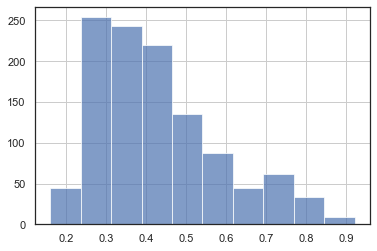

In [199]:
import seaborn as sns
sns.set(style="white")
plt.figure()
score_df['max_1'].hist(alpha=.7, bins=10)
#des_score_df['max_1'].hist(alpha=.7, bins=10)

In [136]:
sm_df = sm_df.merge(score_df, how = 'left', left_index=True, right_index=True)

In [139]:
sm_df.to_csv(args.save_dir+'social_media_pred.csv', encoding='utf-8-sig')
score_df.to_csv(args.save_dir+'social_media_score.csv', encoding='utf-8-sig')

## END